This code is an implementation of the example in https://arxiv.org/abs/2306.17083

In [2]:
from qaoa import QAOA
from qaoa.problems.maxcut_problem import MaxCut
from qaoa.mixers.base_mixer import Mixer
from qaoa.initialstates import InitialState

from qiskit.compiler import transpile
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import XXPlusYYGate, PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM, NFT, NELDER_MEAD

import numpy as np
import networkx as nx
import sys
import matplotlib.pyplot as plt
import math

sys.path.append("../")
from plotroutines import *

ModuleNotFoundError: No module named 'qaoa'

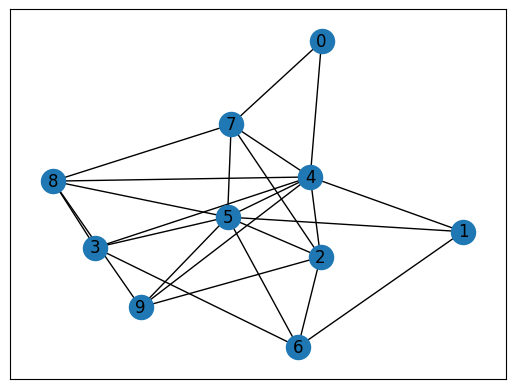

In [2]:
G = nx.read_gml("data/w_ba_n10_k4_0.gml")
nx.draw_networkx(G)
plt.show()

In [3]:
num_cons = 2
k = 6

Precomputed maximum value of the constrained cost function

In [4]:
maxval = 5.965179720554735

In [5]:
class ConstrainedMaxCut_Problem(MaxCut):
    def __init__(self, G, num_cons, k) -> None:
        self.num_cons = num_cons
        self.k = k
        super().__init__(G)

    def isFeasible(string, self):
        cons = 0
        w = 0
        for l in range(self.num_cons):
            c_sum = 0
            for m in range(self.k - 1):
                if w < len(string):
                    c_sum += int(string[w])
                    w += 1
            cons += np.abs(c_sum * (c_sum - 1))
        return math.isclose(cons, 0, abs_tol=1e-4)

In [6]:
class ConstrainedMaxCut_Mixer(Mixer):
    def __init__(self, num_cons, k, depth):
        self.num_cons = num_cons
        self.k = k
        self.depth = depth
        ide = ["I"] * (k - 1)
        ide[0] = "Y"
        Zs = ["Z"] * (k - 1)
        Zs[0] = "Y"
        Zs = "".join(Zs)
        ide = "".join(ide)
        self.op = SparsePauliOp([ide, Zs], coeffs=[1.0, 1.0])

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        mixer_param = Parameter("x_beta")

        self.circuit = QuantumCircuit(q, name="Mixer")
        for r in range(self.depth):
            c = 0
            for i in range(self.num_cons):
                nsubqubits = int(self.N_qubits / self.num_cons)
                self.circuit.append(
                    PauliEvolutionGate(self.op, time=-1 / 2 * mixer_param / self.depth),
                    q[nsubqubits * i : nsubqubits * (i + 1)],
                )
                for j in range(k - 1):
                    if j != 0 and c < self.N_qubits:
                        self.circuit.append(
                            XXPlusYYGate(-2 * mixer_param / self.depth, np.pi),
                            [q[c - 1], q[c]],
                        )
                    c += 1

In [7]:
class ConstrainedMaxCut_InitialState(InitialState):
    def __init__(self, num_cons, k) -> None:
        self.num_cons = num_cons
        self.k = k

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q, name="initial_state")

        k = 0
        for i in range(self.num_cons):
            self.circuit.ry(2 * np.arccos(np.sqrt(1 / (self.k))), q[k])
            for j in range(self.k - 1):
                if not j == self.k - 2:
                    self.circuit.append(
                        XXPlusYYGate(
                            2 * np.arccos(np.sqrt(1 / (self.k - j - 1))), np.pi
                        ),
                        [q[k], q[k + 1]],
                    )
                k += 1

In [8]:
qaoa = QAOA(
    problem=ConstrainedMaxCut_Problem(G, num_cons, k),
    mixer=ConstrainedMaxCut_Mixer(num_cons, k, 1),
    initialstate=ConstrainedMaxCut_InitialState(num_cons, k),
    optimizer=[COBYLA, {"maxiter": 100, "tol": 1e-6, "rhobeg": 1.3}],
    interpolate=False,
    shots=20000,
)

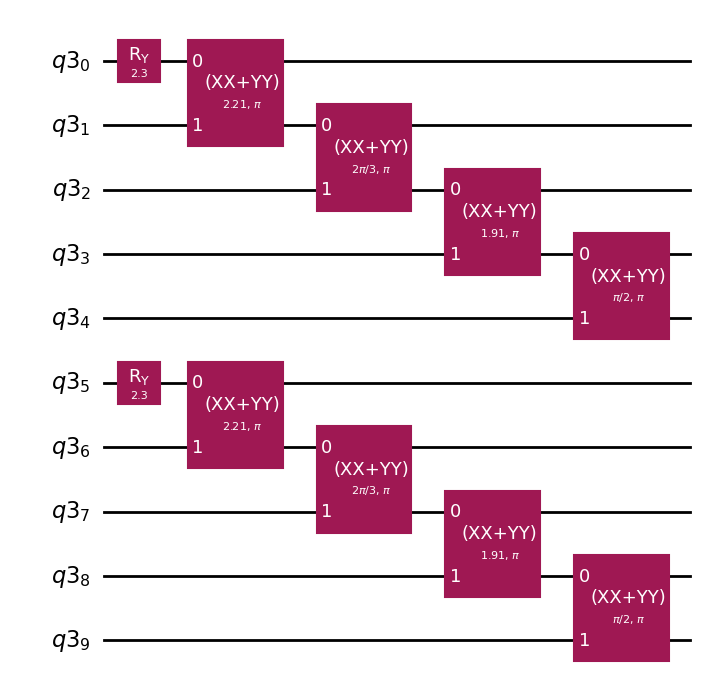

In [9]:
qaoa.createParameterizedCircuit(1)
qaoa.initialstate.circuit.draw("mpl")

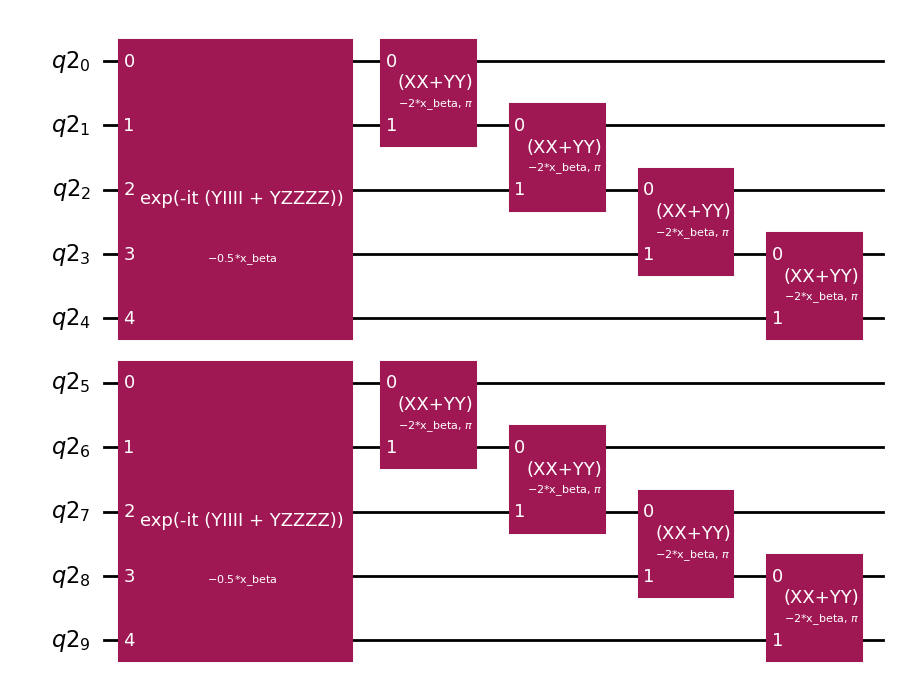

In [10]:
qaoa.mixer.circuit.draw("mpl")

2024-06-27 12:33:09 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2024-06-27 12:33:09 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2024-06-27 12:33:09 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2024-06-27 12:33:09 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2024-06-27 12:33:16 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2024-06-27 12:33:16 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


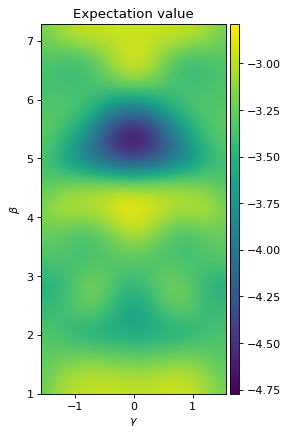

In [11]:
qaoa.sample_cost_landscape(
    angles={"gamma": [-np.pi / 2, np.pi / 2, 15], "beta": [1, 1 + 2 * np.pi, 15]}
)
plot_E(qaoa)

In [12]:
maxdepth = 25
qaoa.optimize(depth=maxdepth)

2024-06-27 12:33:19 [info     ] cost(depth 1 = -4.834151286668523 file=qaoa.qaoa func=optimize
2024-06-27 12:33:23 [info     ] cost(depth 2 = -4.837077199356849 file=qaoa.qaoa func=optimize
2024-06-27 12:33:28 [info     ] cost(depth 3 = -4.8513103581746275 file=qaoa.qaoa func=optimize
2024-06-27 12:33:34 [info     ] cost(depth 4 = -4.871068013750451 file=qaoa.qaoa func=optimize
2024-06-27 12:33:40 [info     ] cost(depth 5 = -4.8758911151873585 file=qaoa.qaoa func=optimize
2024-06-27 12:33:47 [info     ] cost(depth 6 = -4.874516729146314 file=qaoa.qaoa func=optimize
2024-06-27 12:33:54 [info     ] cost(depth 7 = -4.882009944697442 file=qaoa.qaoa func=optimize
2024-06-27 12:34:02 [info     ] cost(depth 8 = -4.881160406124297 file=qaoa.qaoa func=optimize
2024-06-27 12:34:12 [info     ] cost(depth 9 = -4.8817475967393005 file=qaoa.qaoa func=optimize
2024-06-27 12:34:21 [info     ] cost(depth 10 = -4.887004074435511 file=qaoa.qaoa func=optimize
2024-06-27 12:34:30 [info     ] cost(depth 11 

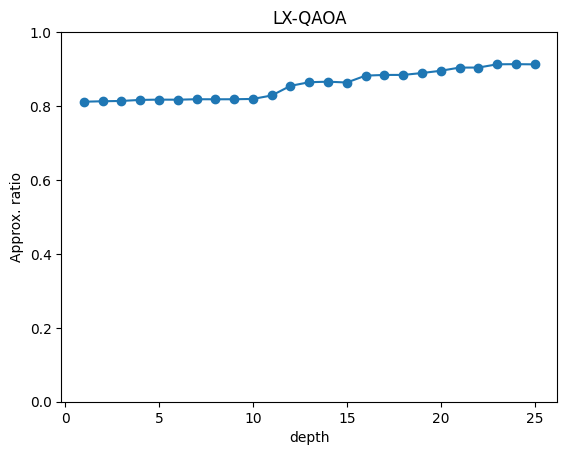

In [13]:
p = np.arange(1, len(np.array(qaoa.get_Exp())) + 1)
plt.plot(p, -np.array(qaoa.get_Exp()) / maxval, marker="o")
plt.xlabel("depth")
plt.ylabel("Approx. ratio")
plt.title("LX-QAOA")
plt.ylim([0, 1])
plt.show()